# Lab 3 - Part 2:
**Student: Nguyen Mai Dinh, Le (Demi, Le)**

**ID: 300312139**

# Image Classification on CIFAR-10 Dataset
> In part #2 of Lab #3, we will use supervised learning to perform classification on images from CIFAR-10 Dataset.

**Learning Objectives:**
1.   Getting familiar with "CIFAR-10 Dataset"
2.   Applying k-NN to perform image classification


# **Getting Started**

# Load the dataset


In [1]:
# Install imageio package, which is used to read and write a wide range of image data
!pip install imageio

In [2]:
# Run some setup code for this notebook.

import random
import numpy as np
from CSIS3290.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# Visualization sample data

In [3]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'CSIS3290/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


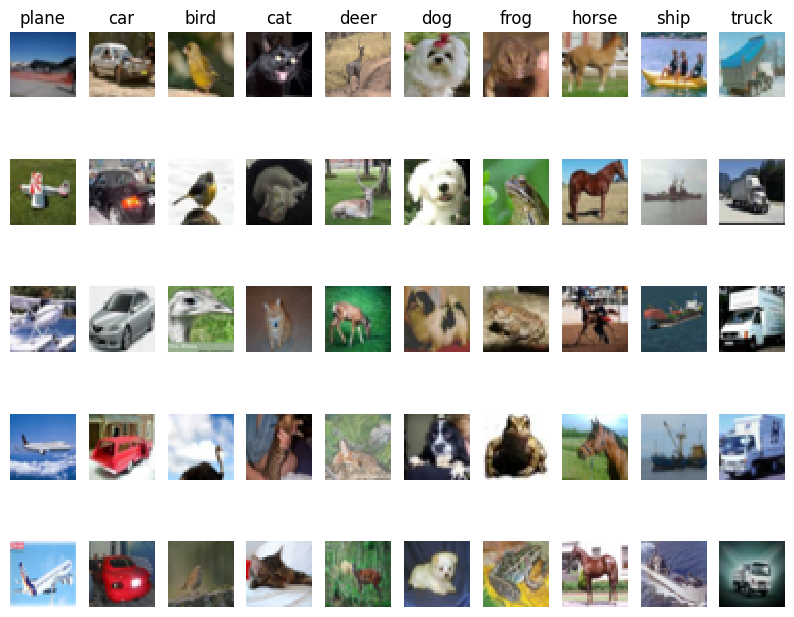

In [4]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 5
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

#Pre-processing

In [5]:
# Subsample the data for more efficient code execution in this exercise
num_training = 5000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


# Build kNN Model

In [6]:
from CSIS3290.classifiers import KNearestNeighbor

# Create a kNN classifier instance.
# Remember that training a kNN classifier is a noop:
# the Classifier simply remembers the data and does no further processing
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

We would now like to classify the test data with the kNN classifier. Recall that we can break down this process into two steps:

1. First we must compute the distances between all test examples and all train examples.
2. Given these distances, for each test example we find the k nearest examples and have them vote for the label

Lets begin with computing the distance matrix between all training and test examples. For example, if there are **Ntr** training examples and **Nte** test examples, this stage should result in a **Nte x Ntr** matrix where each element (i,j) is the distance between the i-th test and j-th train example.


First, open `CSIS3290/classifiers/k_nearest_neighbor.py` and look into the function `compute_distances` that uses a double loop over all pairs of (test, train) examples and computes the distance matrix one element at a time.

In [7]:
# Test the implementation (It might take a while):
dists = classifier.compute_distances(X_test)
print(dists.shape)

(500, 5000)


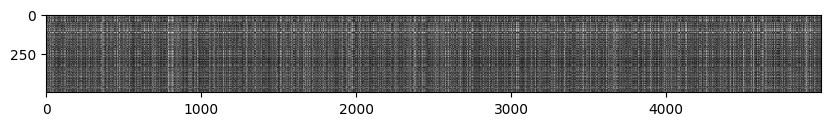

In [8]:
# We can visualize the distance matrix: each row is a single test example and
# its distances to training examples
plt.imshow(dists, interpolation='none')
plt.show()

### **Task 1** [10 points]

Notice the structured patterns in the distance matrix, where some rows or columns are visibly brighter. (Note that with the default color scheme black indicates low distances while white indicates high distances.)

- What in the data is the cause behind the distinctly bright rows?
- What causes the columns?

$\color{orange}{\textit Your Answer:}$ 

According to the logic of the compute_distances function, the dists matrix will have the following structure:

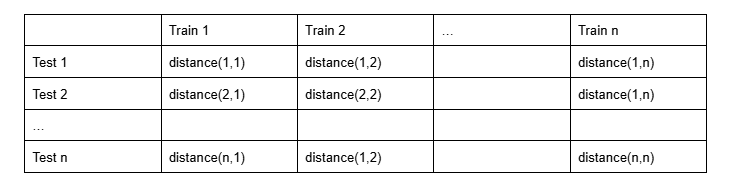

Meaning:
* If a row in the distance matrix is bright (white): This means that the test point i has a large distance from most of the points in the training set. In other words, this test point is far from the training points.
* If a column in the distance matrix is bright (white): This means that the training point j has a large distance from most of the points in the test set. In other words, this training point is far from the test points.

**Causes of bright rows in the distance matrix:**
1. Data not shuffled: If the data is not shuffled before splitting into training and test sets, the classes may be unevenly distributed. This causes a test point from one class to be far from the training points, creating bright rows.
2. Outliers in the test set: Outliers or anomalous test points can create a large distance from most training points, leading to bright rows in the matrix.
3. Differences between classes: Because each class only represents about 10% of the total dataset (as shown below), and if each class is significantly far from the others, then the points in the training set will be far from the points in the test set belonging to the remaining 90% of the classes.


**Causes of bright columns in the distance matrix:**
1. Lack of class representation in the test set: If a class in the training set is not adequately represented in the test set, the training points will have a large distance from the test points, creating bright columns.
2. Outliers in the training set: If there are outliers in the training set, they will have a large distance from the test points, resulting in bright columns.
3. Strong differences between classes: If classes have distinctly different features and are unevenly distributed in both the training and test sets, the training points will be far from the test points from other classes, leading to bright columns.

In [14]:
class_counts = np.bincount(y_train)
for i, count in enumerate(class_counts):
    percentage = count / y_train.shape[0] * 100
    print(f'Class {i}: {percentage}% of total')

Class 0: 10.100000000000001% of total
Class 1: 9.2% of total
Class 2: 10.38% of total
Class 3: 9.719999999999999% of total
Class 4: 10.38% of total
Class 5: 9.76% of total
Class 6: 10.38% of total
Class 7: 9.719999999999999% of total
Class 8: 10.4% of total
Class 9: 9.959999999999999% of total


In [ ]:
# We use k = 1 (which is Nearest Neighbor).
import sklearn.metrics as Metrics
y_test_pred = classifier.predict_labels(dists, k=1)

# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == y_test)
F1_Score = Metrics.f1_score(y_test,y_test_pred, average='macro')
print('Got %d / %d correct => F1_Score: %f' % (num_correct, num_test, F1_Score))

You should expect to see approximately `26%` F1_Score. Now lets try out a larger `k`, say `k = 5`:

In [ ]:
y_test_pred = classifier.predict_labels(dists, k=5)
num_correct = np.sum(y_test_pred == y_test)
F1_Score = Metrics.f1_score(y_test,y_test_pred, average='macro')
print('Got %d / %d correct => F1_Score: %f' % (num_correct, num_test, F1_Score))

You most likely see a slightly better performance with `k = 1`.




### **[Extra Credit: 10 points] Optional Question**

Run the following code to see how long it takes. It will take approximately 35-45 seconds to complete. Can you think of some ways to speed up the process? Feel free to modify any part of the current implementation, if you'd like to.

$\color{orange}{\textit Your Answer:}$


In [83]:
# Let's measure the processing time to see how fast the implementations are
def time_function(f, *args):
    """
    Call a function f with args and return the time (in seconds) that it took to execute.
    """
    import time
    tic = time.time()
    f(*args)
    toc = time.time()
    return toc - tic

processing_time = time_function(classifier.predict, X_test)
print('The current version took %f seconds' % processing_time)


The current version took 22.040005 seconds


# Cross-validation

We have implemented the k-Nearest Neighbor classifier but we set the value k = 5 arbitrarily. We will now determine the best value of this hyperparameter with cross-validation.



**Note:** This step might take quite a while (aproximately 30-50 minutes) to complete (unless you already found some ways to speed up the execution of the code).

### **Task 2**  [20 points]

Complete the following implementation.

In [31]:
from sklearn.metrics import f1_score

num_folds = 5
k_choices = [1, 3, 5, 7, 10, 15, 20, 40, 80]

X_train_folds = []
y_train_folds = []
################################################################################                                                                       #
# Split up the training data into folds. After splitting, X_train_folds and    #
# y_train_folds should each be lists of length num_folds, where                #
# y_train_folds[i] is the label vector for the points in X_train_folds[i].     #
# Hint: Look up the numpy array_split function.                                #
################################################################################

X_train_folds = np.array_split(X_train, num_folds)
y_train_folds = np.array_split(y_train, num_folds)


# A dictionary holding the accuracies for different values of k that we find
# when running cross-validation. After running cross-validation,
# k_to_accuracies[k] should be a list of length num_folds giving the different
# accuracy values that we found when using that value of k.
k_to_F1_Score = {}


################################################################################
# TODO:                                                                        #
# Perform k-fold cross validation to find the best value of k. For each        #
# possible value of k, run the k-nearest-neighbor algorithm num_folds times,   #
# where in each case you use all but one of the folds as training data and the #
# last fold as a validation set. Store the accuracies for all fold and all     #
# values of k in the k_to_accuracies dictionary.                               #
################################################################################

for k in k_choices:
    k_to_F1_Score[k] = []
    for i in range(num_folds):
        # prepare training data for the current fold
        X_train_fold = np.concatenate([ fold for j, fold in enumerate(X_train_folds) if i != j ])
        y_train_fold = np.concatenate([ fold for j, fold in enumerate(y_train_folds) if i != j ])

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        # use of k-nearest-neighbor algorithm
        X_test_fold = X_train_folds[i]
        y_test_fold = y_train_folds[i]
        classifier = KNearestNeighbor()
        classifier.train(X_train_fold, y_train_fold)

        
        y_pred_fold = classifier.predict(X_test_fold, k=k)
        

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        # Compute the fraction of correctly predicted examples
        num_correct = np.sum(y_pred_fold == y_train_folds[i])
        F1_Score = f1_score(y_train_folds[i], y_pred_fold, average='macro')
        k_to_F1_Score[k].append(F1_Score)


# Print out the computed accuracies
for k in sorted(k_to_F1_Score):
    for score in k_to_F1_Score[k]:
        print('k = %d, F1_Score = %f' % (k, score))

k = 1, F1_Score = 0.244208
k = 1, F1_Score = 0.244982
k = 1, F1_Score = 0.252613
k = 1, F1_Score = 0.266924
k = 1, F1_Score = 0.251067
k = 3, F1_Score = 0.218351
k = 3, F1_Score = 0.235785
k = 3, F1_Score = 0.218676
k = 3, F1_Score = 0.243797
k = 3, F1_Score = 0.220578
k = 5, F1_Score = 0.219634
k = 5, F1_Score = 0.243921
k = 5, F1_Score = 0.249768
k = 5, F1_Score = 0.274499
k = 5, F1_Score = 0.243190
k = 7, F1_Score = 0.231389
k = 7, F1_Score = 0.250458
k = 7, F1_Score = 0.236422
k = 7, F1_Score = 0.270754
k = 7, F1_Score = 0.235118
k = 10, F1_Score = 0.226867
k = 10, F1_Score = 0.265533
k = 10, F1_Score = 0.248307
k = 10, F1_Score = 0.255740
k = 10, F1_Score = 0.238528
k = 15, F1_Score = 0.215068
k = 15, F1_Score = 0.259531
k = 15, F1_Score = 0.242220
k = 15, F1_Score = 0.258725
k = 15, F1_Score = 0.227705
k = 20, F1_Score = 0.234506
k = 20, F1_Score = 0.247243
k = 20, F1_Score = 0.237140
k = 20, F1_Score = 0.258207
k = 20, F1_Score = 0.233431
k = 40, F1_Score = 0.233009
k = 40, F1_S

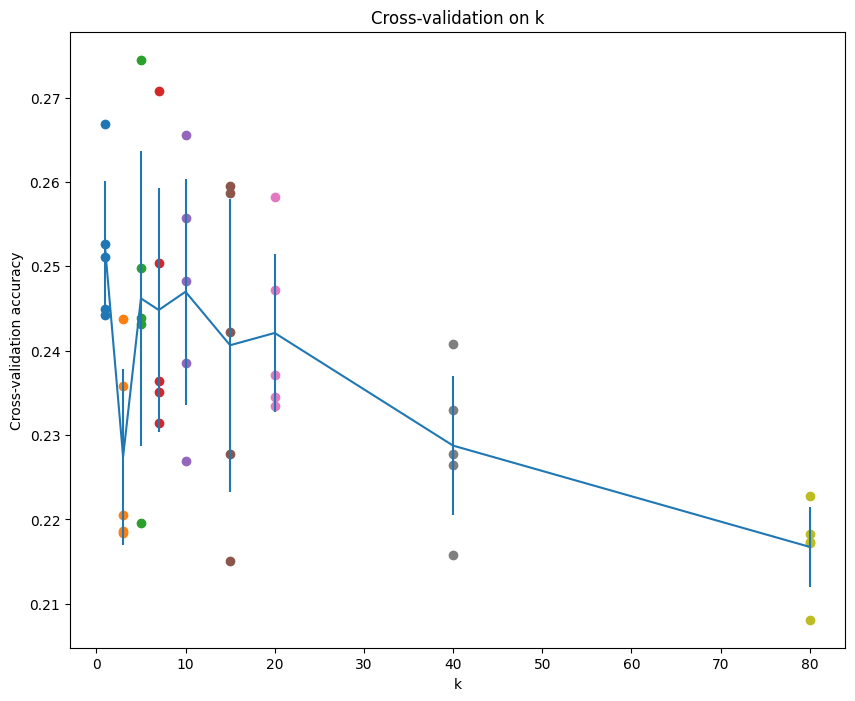

In [32]:
# plot the raw observations
for k in k_choices:
    accuracies = k_to_F1_Score[k]
    plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_F1_Score.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_F1_Score.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [47]:
from sklearn.metrics import accuracy_score
# Based on the cross-validation results above, choose the best value for k,
# retrain the classifier using all the training data, and test it on the test
# data. You should be able to get above 28% accuracy on the test data.
best_k = 10 #Replace this with the best k value

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
F1_Score = f1_score(y_test,y_test_pred, average='macro')
accuracy = accuracy_score(y_test, y_test_pred)

print('Got %d / %d correct => F1_Score: %f, Accuracy: %f' % (num_correct, len(y_test), F1_Score, accuracy))

Got 141 / 500 correct => F1_Score: 0.240165, Accuracy: 0.282000


### **Task 3**  [20 points]

For each of the following statements about $k$-Nearest Neighbor ($k$-NN), indicate whether they are True/False in a classification setting? Briefly justify your answer in each case.

$\color{Orange}{\textit Your Answer:}$

1. The decision boundary of the k-NN classifier is linear.
   
    **FALSE:** KNN is a non-linear classification method because it does not rely on a fixed hyperplane to separate data classes. Instead, KNN classifies a data point based on the voting results from its nearest neighbors. It is formed by groups of nearby data points and changes depending on the distribution of points in the space and the value of k (the number of nearest neighbors).
   
2. The training error of a 1-NN will always be lower than or equal to that of 8-NN.

   **TRUE:** When using 1-NN, the classifier relies on the closest point, which is the point itself. This leads to the classifier predicting perfectly for the training data itself, as each point predicts correctly itself by taking only its own information, resulting in a training error of 0. Therefore, the training error of 1-NN will be the lowest compared to other KNN values
3. The test error of a 1-NN will always be lower than that of a 8-NN.

   **FALSE:** When k=1, the classifier relies solely on the information from the closest neighbor to make predictions, which can lead to overfitting. Since the model memorizes the training set, it may perfectly predict the training data but fail to generalize well to new data. This results in higher test error, potentially even higher than that of an 8-NN. On the other hand, an 8-NN classifier makes predictions based on the information from 8 nearest neighbors, which provides a more objective and generalized result. This makes the model more robust and less likely to overfit, leading to lower test error.
4. The time needed to classify a test example with the k-NN classifier grows with the size of the training set.

   **TRUE:** In the k-NN algorithm, there is no pre-learned model (e.g., a decision boundary like in linear classifiers). Instead, the classification of a test example is based on the k nearest neighbors from the training set. To determine these nearest neighbors, the algorithm needs to scan through the entire training dataset for each test point. As the size of the training set increases, the time required to classify a test example also increases because the algorithm must compare the test point to every point in the training set to identify the nearest neighbors. Therefore, the time needed for classification grows with the size of the training set.

8. For k=n (number of data points), k-NN will be in its most complex form with highest flexibility!

   **FALSE:** When k=n, the model memorizes the entire training set. When a new data point is introduced, the model will always predict the most frequent class as the label for the new data (leading to underfitting). This happens because the decision boundary becomes very simple, as the class prediction is based on the entire training set, rather than the local neighborhood of the new data point. Therefore, the model becomes overly simplistic and lacks flexibility, as it does not adapt to the position of the test data points or capture local variations in the data


